## CORE

In [1]:
!pip install fastcore fastai2 transformers -q

In [1]:
from fastcore.foundation import *
from fastai2.text.all import *
import transformers
import pathlib

In [2]:
@patch
def ls(x: pathlib.Path):
    return list(x.iterdir())

In [3]:
# import os
# from pathlib import Path
from google.colab import drive

In [4]:
def create_path(path):
    if not os.path.isdir(path):
        path.mkdir(parents=True, exist_ok=True)
    return path

In [5]:
colab_path = Path('/content')

handles all gdrive downloads for when running on cluster

In [ ]:
create_path(colab_path/'dataset');
create_path(colab_path/'models');

!git clone --quiet 'https://github.com/tezike/download_google_drive.git'
os.chdir('download_google_drive')
!python download_gdrive.py '10rH0nAxa7mWS289xIyRP-mOOowqiIolL' '../dataset/temp.tgz'
shutil.rmtree('../download_google_drive')
os.chdir('..')

## Colab_setup

In [6]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = Path('/content/drive/My Drive')
base_path = create_path(root_dir/'Rakuten')
base_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path('/content/drive/My Drive/Rakuten')

## download and untar data

In [9]:
!tar -xzf $colab_path/'dataset/temp.tgz' # && tar -xzf ${colab_path/'lm-encoder-splits.tar.gz'} -C ${colab_path}

## FIN

## Config

In [7]:
class Config():
    def __init__(self):
        self.MODEL_NAME = 'xlm-roberta-base'
        self.LM_MODEL = transformers.XLMRobertaForMaskedLM.from_pretrained(self.MODEL_NAME)
        self.CLAS_MODEL = transformers.XLMRobertaModel #.from_pretrained(MODEL_NAME)
        self.TOKENIZER = transformers.XLMRobertaTokenizer.from_pretrained(
                    pretrained_model_name_or_path=self.MODEL_NAME,
                    do_lower_case=True,
                    )
        self.MODEL_CONFIG = transformers.XLMRobertaConfig.from_pretrained(self.MODEL_NAME)
        self.COLAB_PATH = Path('/content')
        self.BASE_PATH = base_path
        self.DATA_PATH = create_path(base_path/'dataset')
        self.MODEL_PATH = create_path(base_path/'models')
        self.TEST_FILE = self.COLAB_PATH/'SIGIR-2020-EComDC-release/data/x_test_task1_phase1.tsv'
        self.MAX_SEQ_LEN = 512
        self.DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

config = Config()

In [56]:
class Config():
    def __init__(self):
        self.MODEL_NAME = 'roberta-base'
        self.LM_MODEL = transformers.RobertaForMaskedLM.from_pretrained(self.MODEL_NAME)
        self.CLAS_MODEL = transformers.RobertaForSequenceClassification #.from_pretrained(MODEL_NAME)
        self.TOKENIZER = transformers.RobertaTokenizer.from_pretrained(
                    pretrained_model_name_or_path=self.MODEL_NAME,
                    do_lower_case=True,
                    )
        self.MODEL_CONFIG = transformers.RobertaConfig.from_pretrained(self.MODEL_NAME)
        self.COLAB_PATH = Path('/content')
        self.BASE_PATH = base_path
        self.DATA_PATH = create_path(base_path/'dataset')
        self.MODEL_PATH = create_path(base_path/'models')
        self.TEST_FILE = self.COLAB_PATH/'SIGIR-2020-EComDC-release/data/x_test_task1_phase1.tsv'
        self.MAX_SEQ_LEN = 512
        self.DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

config_rob = Config()

In [191]:
# config.TOKENIZER.build_inputs_with_special_tokens(config.TOKENIZER.convert_tokens_to_ids(config.TOKENIZER.tokenize('he is a sheep', add_prefix_space=True)))

## TOKENIZER

In [29]:
config.DATA_PATH.ls()

[Path('/content/drive/My Drive/Rakuten/dataset/._SIGIR-2020-EComDC-release'),
 Path('/content/drive/My Drive/Rakuten/dataset/SIGIR-2020-EComDC-release'),
 Path('/content/drive/My Drive/Rakuten/dataset/temp.tgz'),
 Path('/content/drive/My Drive/Rakuten/dataset/rand_splits_10000_baseline.npy'),
 Path('/content/drive/My Drive/Rakuten/dataset/submission_baseline_10000_score_38.4.csv'),
 Path('/content/drive/My Drive/Rakuten/dataset/submission_baseline_10000_score_38.4.tsv'),
 Path('/content/drive/My Drive/Rakuten/dataset/rand_files_sample_10000.npy'),
 Path('/content/drive/My Drive/Rakuten/dataset/sample_df.csv'),
 Path('/content/drive/My Drive/Rakuten/dataset/df_all.csv')]

In [8]:
transformer_vocab = config.TOKENIZER.get_vocab()
trans2fastai_vocab = [k for k, v in sorted(transformer_vocab.items(), key=lambda item: item[1])]
len(trans2fastai_vocab)

250002

In [9]:
class HFTokenizer():
    def __init__(self, tokenizer=config.TOKENIZER, seq_len=config.MAX_SEQ_LEN):
        self.tok = tokenizer
        self.seq_len = seq_len

    def tokenize(self, text):

        tokens = self.tok.tokenize(text)

        return tokens

    def __call__(self, items:Str):
        # ALways yeild the tokenized text before passing it to the Tokenizer Transform
        tokenized = []
        for text in items:
            yield self.tokenize(text)[:self.seq_len-2]
            # tokenized.append(self.tokenize(text)[:self.seq_len-2])
        return tokenized

In [10]:
class Add_Special_Cls(Transform):
    order = 7
    def __init__(self, tokenizer=config.TOKENIZER):
        self.tok = tokenizer

    def encodes(self, o):
        return TensorText(self.tok.build_inputs_with_special_tokens(list(o)))

In [11]:
@Tokenizer
def decodes(self, o): return TitledStr(str(self.tokenizer.tok.convert_tokens_to_string(o)))

In [11]:
custom_tokenizer = Tokenizer.from_df(text_cols=['Title', 'Description'], tok_func=HFTokenizer, rules=[fix_html], post_rules=[])

In [12]:
df_all = pd.read_csv(config.BASE_PATH/'dataset/df_all.csv'); df_all.sample(1)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
31150,Bebek Bébé En Peluche Hochets Poignée De Traction Jouer Jouets Lit Bébé Poussette Hanging Jeux Éducatifs 1388,Enfant en peluche hochets poignée de traction Jouer Jouets Lit bébé poussette Hanging Feature: 100% tout neuf et haute. Quantité: 1 Très doux et confortable au toucher Un grand jouet en peluche pour vos enfants grand cadeau pour l&#39;anniversaire de mariage et bébé Taille: 11cmX7cm peut choisir: sous-marin fusée bateau de voiture Contenu: 1X Peluche animal bébé bébé enfants Clochettes hochets pour bébé Kid cadeau,1254358095,3861177097,1280,1280,/content/SIGIR-2020-EComDC-release/image/image_training/image_1254358095_product_3861177097.jpg


# MLM

In [18]:
class MLM(Transform):
    def __init__(self, tokenizer, mlm_prob=0.15, mask_prob = 0.8):
        """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """

        self.tokenizer = tokenizer
        self.mlm_prob, self.mask_prob = mlm_prob, mask_prob

        if self.tokenizer.mask_token is None:
            raise ValueError(
                "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
            )

    def prob_matrix(self, inputs):
        labels = inputs.clone()
        # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
        probability_matrix = torch.full(labels.shape, self.mlm_prob)
        # print(probability_matrix)
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(labels.tolist(), already_has_special_tokens=True)
        # place 0 at the places where we have these special tookens
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        if self.tokenizer.pad_token is not None:
            # check if the any element in input is equal to the pad token
            padding_mask = labels.eq(self.tokenizer.pad_token_id)
            # if a pad tok is hit, fill the prob_mat with 0.0 for that pad so the model won't attend to it
            probability_matrix.masked_fill_(padding_mask, value=0.0)

        return probability_matrix, labels

    def encodes(self, inputs):
        probability_matrix, labels = self.prob_matrix(inputs)

        # use a prop dist to select points in the input sentence token that we want to mask. convert these binary points to bool
        masked_indices = torch.bernoulli(probability_matrix).bool()
        # anyplace that isn't a mask, replace with -100 so loss won't be computed on it
        labels[~masked_indices] = -100  # We only compute loss on masked tokens
        # # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
        # out of the mask_indices, select a percentage that will be masked
        indices_replaced = torch.bernoulli(torch.full(labels.shape, self.mask_prob)).bool() & masked_indices

        # replace all the mask hits in the original input with the mask token id
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # # 10% of the time, we replace masked input tokens with random word
        # replace the previous masks a percentage of the time making sure the tokens to be replaced are not in the sub mask we just created
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        # get out some random token
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
        # replace the some of the masked inputs with random words
        inputs[indices_random] = random_words[indices_random]

        # # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        return inputs, labels

In [20]:
@Numericalize
def decodes(self, o):
    '''set the new mask at positions where the token_ids is -100'''
    tmp_vocab = self.vocab.copy()
    
    tmp_vocab.append('<loss_mask>')

    o = [-1 if o_ == -100 else o_ for o_ in o]
    return (tmp_vocab[o_] for o_ in o if tmp_vocab[o_] != config.TOKENIZER.pad_token_id)

In [21]:
def pad_input_chunk(samples, pad_idx=1, pad_first=True, seq_len=config.MAX_SEQ_LEN):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    max_len = max([len(s[0]) for s in samples])
    def _f(x):
        l = max_len - x.shape[0]
        pad_chunk = x.new_zeros((l//seq_len) * seq_len) + pad_idx
        pad_res   = x.new_zeros(l % seq_len) + pad_idx
        x1 = torch.cat([pad_chunk, x, pad_res]) if pad_first else torch.cat([x, pad_res, pad_chunk])
        return retain_type(x1, x)
    return [(_f(s[0]), _f(s[1])) for s in samples]

In [22]:
pad = partial(pad_input_chunk, pad_idx=config.TOKENIZER.pad_token_id, pad_first=False, seq_len=config.MAX_SEQ_LEN)

##DAtaset

In [24]:
splits = RandomSplitter()(df_all[:500])

In [25]:
tfms = [attrgetter('text'), 
            custom_tokenizer, Numericalize(vocab=trans2fastai_vocab), 
            Add_Special_Cls, MLM(config.TOKENIZER)]

In [26]:
dsets = TfmdLists(df_all[:500], tfms, splits=splits, dl_type=SortedDL)

In [27]:
dsets.decode(dsets[0])

("<s> xxfld<mask> journal des arts (le) n° 133 du 28/09/2001 - l<mask>art<mask> son<mask> salon<mask>'<mask> asiatique a<mask>is - ja<mask>ques barre клієнт - francois perrier<mask> la reforme des vente<mask> aux<mask>cheres publiques - le sna fete ses cent ans. xxfl<mask> 2<mask></s>",
 "<s><loss_mask><loss_mask><loss_mask> 1<loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask>'<loss_mask> et<loss_mask> marche<loss_mask> d<loss_mask>art<loss_mask><loss_mask><loss_mask> par<loss_mask><loss_mask><loss_mask>c<loss_mask><loss_mask>re<loss_mask><loss_mask><loss_mask><loss_mask><loss_mask> -<loss_mask><loss_mask>e<loss_mask><loss_mask>s<loss_mask> en<loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask><loss_mask>d<loss_mask> nan</s>")

In [28]:
dls = dsets.dataloaders(bs=3, before_batch=[pad])

In [29]:
b = dls.one_batch()

In [ ]:
# dls.show_batch()

## Language Model

In [32]:
class MLModel(nn.Module):
    def __init__(self, model=config.LM_MODEL, tokenizer=config.TOKENIZER):
        super(MLModel, self).__init__()
        self.model = model

    def forward(self, inp):
        attention_mask = (inp != config.TOKENIZER.pad_token_id).type(inp.type()) 
        out = self.model(inp, attention_mask=attention_mask)
        return out[0]

In [33]:
model = MLModel()

opt_func = partial(Adam, decouple_wd=True)

loss_func = CrossEntropyLossFlat()

learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func,metrics=[accuracy, perplexity]).to_fp16()

In [34]:
import gc; gc.collect()

830

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=2.75422871709452e-06)

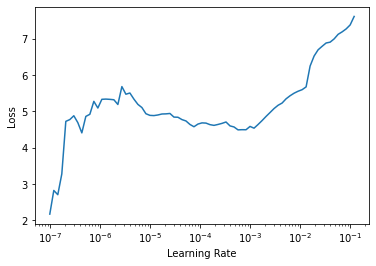

In [35]:
learn.lr_find()

In [36]:
# learn.summary()

In [37]:
# learn.validate()

In [38]:
learn.fit_one_cycle(3, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.912897,2.095650,0.120566,8.130728,29:08
1,1.617106,1.666066,0.129951,5.291311,29:08
2,1.348014,1.527953,0.132507,4.608732,29:10


In [40]:
learn.path = config.MODEL_PATH;
learn.path

Path('/content/drive/My Drive/Rakuten/models')

In [41]:
# learn.save('This is the encoder')
learn.export(fname='roberta_pretrained_lm.pkl')

In [45]:
learn.show_results(max_n=1)

## Inference

In [47]:
df_all.Title[9]

'Contrôleur De Jeu Mobile Tir Sensible Et But Joysticks Poignée Gamepad Pour Pubg'

In [54]:
masked_text = 'Contrôleur De Jeu Mobile Tir Sensible Et But <mask> Poignée Gamepad Pour Pubg'

In [56]:
masked_text = "C'est un mot français que je viens de <mask>"

In [57]:
masked_tokens = custom_tokenizer.encodes(masked_text)
masked_token_ids = Numericalize(vocab=trans2fastai_vocab)(masked_tokens)
masked_token_ids = Add_Special_Cls()(masked_token_ids)

with torch.no_grad():
    model.eval()
    out = learn.model(masked_token_ids[None].cuda())
# get the probability of the logits predicted where the mask occurs
masked_index = torch.where(masked_token_ids == config.TOKENIZER.mask_token_id)[0].numpy().item()
# print(masked_tokens)
# print(masked_index)
logits = out[:, masked_index, :]
out = F.softmax(logits, dim=1)
# get the top k preds
score, pred = out.topk(5)

result = []

for i, (score_, pred_) in enumerate(zip(score[0].tolist(), pred[0].tolist())):
    tokens = masked_token_ids.numpy()
    tokens[masked_index] = pred_
    tokens = tokens[np.where(tokens != config.TOKENIZER.pad_token_id)]
    w = dsets.decode(tokens)
    print(f'Input: {masked_text}')
    print(f'Pred: {w}')
    print(f'score= {score_} \n')

Input: C'est un mot français que je viens de <mask>
Pred: <s>c'est un mot français que je viens deux</s>
score= 0.04931799694895744 

Input: C'est un mot français que je viens de <mask>
Pred: <s>c'est un mot français que je viens de jour</s>
score= 0.03146360442042351 

Input: C'est un mot français que je viens de <mask>
Pred: <s>c'est un mot français que je viens de plus</s>
score= 0.029756130650639534 

Input: C'est un mot français que je viens de <mask>
Pred: <s>c'est un mot français que je viens de.</s>
score= 0.022600935772061348 

Input: C'est un mot français que je viens de <mask>
Pred: <s>c'est un mot français que je viens de …</s>
score= 0.021387362852692604 



# Classifier

In [13]:
def pad_input_chunk(samples, pad_idx=1, pad_first=True, seq_len=72):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    max_len = max([len(s[0]) for s in samples])
    def _f(x):
        l = max_len - x.shape[0]
        pad_chunk = x.new_zeros((l//seq_len) * seq_len) + pad_idx
        pad_res   = x.new_zeros(l % seq_len) + pad_idx
        x1 = torch.cat([pad_chunk, x, pad_res]) if pad_first else torch.cat([x, pad_res, pad_chunk])
        return retain_type(x1, x)
    return [(_f(s[0]), *s[1:]) for s in samples]

In [14]:
pad = partial(pad_input_chunk, pad_idx=config.TOKENIZER.pad_token_id, pad_first=False, seq_len=config.MAX_SEQ_LEN)

In [15]:
tfms = [attrgetter('text'), 
            custom_tokenizer, Numericalize(vocab=trans2fastai_vocab), 
            Add_Special_Cls]

In [16]:
splits = RandomSplitter()(df_all)

In [17]:
dsets = Datasets(df_all, tfms=[tfms, [attrgetter('Prdlbl'), Categorize]], splits=splits, dl_type=SortedDL)

In [18]:
dls_clas = dsets.dataloaders(bs=4, val_bs=4, before_batch=[pad], seq_len=config.MAX_SEQ_LEN)

In [40]:
dls_clas.show_batch()

,text,category
0,<s> xxfld 1 décoration du foyer coussin trou noir stellaire taie d'oreiller jeter covers cc4440 xxfld 2 décoration du foyer coussin stellar trou noir taie coussin couvre point de vente de produits: décoration de la maison: throw taies d&'oreiller sont perfert pour décorer votre chambre .suitable pour le salon chambre à coucher un canapé un canapé voiture siège sol banc bureau café partie ect. fermeture à glissière est caché et smoothly.putting votre insert dans puis de nouveaux coussins pourrait terminée. insert d&'oreiller pourrait facilement être frappé légèrement ou enlevé vous pouvez laver taie d&'oreiller en tout temps de sorte que votre oreiller jet pourrait toujours garder propre et belle. conseils de lavage: lavage en machine à froid séparément doucement cycle seulement dot non eau de javel sèche-linge ne pas repasser et il va tout nouveau look. le motif imprimé est disponible uniquement sur la face avant arrière sans impression grand,1920
1,<s> xxfld 1 peinture décorative salle de bedroomliving tv murale décoration murale mureaux xxfld 2 peinture décorative salle de bedroomliving tv murale décoration murale mureaux caractéristiques: 100% tout neuf et de haute qualité. quantité: 1pc protection non toxique environnement imperméable matière: pvc motif: avion autocollant mural facile à appliquer supprimer déplacer et réutiliser sans laisser de dommage ou de résidus. la taille mesurée manuellement. la tolérance est de 1 cm. peut être appliqué sur toute surface sans poussière lisse sec comme porte en verre vitre carreaux de céramique dans la cuisine ou salle de bain lunettes appareils ménagers air conditionné et le corps de voiture nous faisons de notre meilleur spectacle du produit réel. mais s&'il vous plaît comprendre la couleur encore peut-être un peu différent selon l&'effet illustration et de l&'écran. un sticker mural art mur beautiflu pour votre maison ou au bureau donnera à votre pièce un aspect,2060
2,"<s> xxfld 1 papier peint | fond illuminé | 300x231 | | xxfld 2 <strong>papier peint</strong> intissé ""fond illuminé"" solide résistant à l&'eau et aux rayures est à poser au mur. papier peint intissé ""fond illuminé"" représentant un motif inspiré sera une décoration particulière pour toutes les pièces. les papiers peints intissés sont posés au mur avec une colle speciale .celui-ci peut être posé dans chaque pièce une salle de bain et dans la cuisine. il se distingue par une surface demi terne et couvre les imperfections du mur. <strong>impression de la haute qualité</strong> l&'impression numérique de la résolution de 600dpi dans la technologie unique et les couleurs vives de papier peint intissé font remplir votre mur et agrandir votre intérieur. celui-ci forme une couche isolante et permet aux murs de respirer. l&'impression résistante à l&'eau est très durable. <strong>eco et en sécurité</strong> en utilisant des matériaux fiables nos papiers",2060
3,<s> xxfld 1 v-rally 4 - jeu en téléchargement xxfld 2 <div> <p><strong>note :</strong> un compte steam et une connexion internet sont nécessaires pour activer télécharger et utiliser ce produit.</p> offre de précommande <div> <p>profitez d&'un accès anticipé à la légendaire ford shelby gt500</p> </div> à propos du jeu <p>le retour d&'une légende des jeux de course off-road ! vivez une expérience extrême en maîtrisant une simulation exigeante. relevez les défis du rallye du rallycross du drift du buggy ou de l&'hill climb et partez pour un voyage spectaculaire sur tous les continents.</p> <p>dominez des routes dangereuses des conditions et des environnements hostiles recherchez toujours plus de vitesse et laissez l&'adrénaline booster vos réflexes. au volant des bolides off-road les plus mythiques de chaque catégorie affrontez les tracés les plus difficiles dans de fabuleux décors.</p> <ul><li><strong>rallye :</strong> du kenya à sequoia park dominez les tracés les plus difficiles dans des,2905


## For clas learner

In [19]:
def roberta_cls_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.model.embeddings,
                  m.model.encoder.layer[0],
                  m.model.encoder.layer[1],
                  m.model.encoder.layer[2],
                  m.model.encoder.layer[3],
                  m.model.encoder.layer[4],
                  m.model.encoder.layer[5],
                  m.model.encoder.layer[6],
                  m.model.encoder.layer[7],
                  m.model.encoder.layer[8],
                  m.model.encoder.layer[9],
                  m.model.encoder.layer[10],
                  m.model.encoder.layer[11],
                  m.model.pooler)]
    groups = L(groups + [m.lin])
    return groups.map(params)

In [20]:
class Clas_Model(nn.Module):
    def __init__(self, pretrained=True, num_classes=dls_clas.c, load_encoder=True):
        super(Clas_Model, self).__init__()
        if pretrained:
            self.model = config.CLAS_MODEL(config.MODEL_CONFIG)

        else: 
            self.model = config.CLAS_MODEL.from_pretrained(config.MODEL_NAME)

        if load_encoder: self.load_lm_encoder(self.model, config.MODEL_PATH/'roberta_pretrained_lm.pkl')
        
        self.drop = nn.Dropout(0.2)

        self.lin = nn.Linear(768*2, num_classes)
    
    def forward(self, x):
        attention_mask =  (x!=config.TOKENIZER.pad_token_id).type(x.type())

        h_0, _ = self.model(x, attention_mask=attention_mask)
        
        mean_pool = torch.mean(h_0, 1)

        max_pool = torch.max(h_0, 1)[0]

        out = torch.cat([mean_pool, max_pool], 1)

        out = self.lin(self.drop(out))

        return out

    def load_lm_encoder(self,clas_model, lm_path=None):
        clas_model_dict = clas_model.state_dict()
        if lm_path is not None:
            lm_model_dict = torch.load(lm_path).model.state_dict()
            needed_dict = {k[6:]:v for k, v in lm_model_dict.items() if str(k)[6:] in clas_model_dict.keys()}
            clas_model_dict.update(needed_dict)
        clas_model.load_state_dict(clas_model_dict)

In [21]:
model = Clas_Model(pretrained=True, load_encoder=False)

In [22]:
opt_func = partial(Adam, decoupled_wd=True) #AdamW
learn = Learner(dls_clas, model, metrics=accuracy, drop_mult=0., loss_func=CrossEntropyLossFlat(), opt_func=opt_func)

Make only the last layer trainable then gradually unfreeze the rest

In [124]:
# learn.freeze()

In [35]:
learn.summary()

Clas_Model (Input shape: ['4 x 87'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            4 x 87 x 768         192,001,536 True      
________________________________________________________________
Embedding            4 x 87 x 768         394,752    True      
________________________________________________________________
Embedding            4 x 87 x 768         768        True      
________________________________________________________________
LayerNorm            4 x 87 x 768         1,536      True      
________________________________________________________________
Dropout              4 x 87 x 768         0          False     
________________________________________________________________
Linear               4 x 87 x 768         590,592    True      
________________________________________________________________
Linear               4 x 87 x 768         590,592    True      
____________________________________________________________

In [54]:
import gc; 
gc.collect()

792

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=1.3182567499825382e-06)

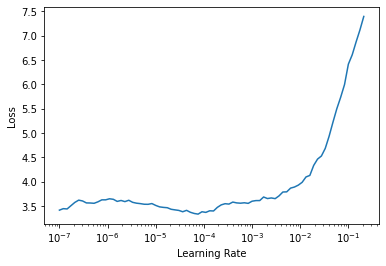

In [128]:
learn.lr_find()

In [44]:
lr = 1e-05

In [45]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.873560,2.860932,0.089000,15:10
1,1.956807,1.998694,0.420000,15:32
2,1.533745,1.407617,0.591500,15:27
3,1.145570,1.297458,0.610000,15:40
4,0.824155,1.118888,0.661000,15:31
5,0.784426,1.086315,0.679000,15:35


In [24]:
learn.path = config.MODEL_PATH

In [48]:
learn.export('pretrained_xlmroberta.pkl')

In [58]:
learn = load_learner(config.MODEL_PATH/'pretrained_xlmroberta.pkl', cpu=False)

RuntimeError: ignored

In [ ]:
learn.dls = dls_clas

## Inference

In [46]:
test_df = pd.read_csv(config.TEST_FILE, sep='\t').fillna(' ')
len(test_df)

937

In [51]:
test_items = TfmdLists(test_df, [attrgetter('text'), custom_tokenizer, Numericalize(vocab=trans2fastai_vocab), Add_Special_Cls])

In [147]:
# test_dl = test_items.dataloaders(bs=4, before_batch=[pad], seq_len=config.MAX_SEQ_LEN)

Could not do one pass in your dataloader, there is something wrong in it


In [57]:
learn.model.eval()
with torch.no_grad():
    for ti in test_items:
        out = learn.model(torch.cat((ti[None], tensor([0] * 5)[None]), dim=1).cuda())
        print(out.shape)
        break

RuntimeError: ignored

In [121]:
test_items = tokenize_df(df=test_df, text_cols=['Title', 'Description'], tok_func=HFTokenizer, res_col_name='text')

In [52]:
_test_dl = learn.dls.test_dl(test_items=test_items)

In [55]:
# preds, _, preds_raw = 
learn.get_preds(dl=_test_dl, with_decoded=False, with_input=True)

IndexError: ignored

In [ ]:
preds

tensor([[9.9767e-01],
        [2.4747e-06],
        [2.0972e-06],
        ...,
        [1.0581e-05],
        [9.9848e-01],
        [8.9927e-01]])

In [ ]:
any(preds) == any(preds_raw)

True

In [ ]:
preds = sum(all_preds)/ len(all_preds)

In [ ]:
preds

tensor([8.8596e-01, 5.9015e-05, 1.9469e-03,  ..., 5.2246e-05, 8.8848e-01,
        8.1959e-01])

In [ ]:
sample = pd.read_csv(data_path/'sub.csv')
# sample.loc[:, 'label'] = preds.flatten()
sample.loc[:, 'target'] = preds

sample.to_csv("roberta-vaccine-submission.tsv", index=False, sep='\t')